# Exploratory Data Analysis

### By Natalia López Gallego

-----------------------------------------------------------------------------



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
data = [
    "../data/external/2015.csv",
    "../data/external/2016.csv",
    "../data/external/2017.csv",
    "../data/external/2018.csv",
    "../data/external/2019.csv"
]

dfs = {}  # Dictionary to save DataFrames by year

for file in data:
    # Extract year from filename correctly
    year = file.split("/")[-1][:4]  # "2015.csv" → "2015"
    df = pd.read_csv(file)
    dfs[year] = df  # Save the DataFrame with key = year

In [4]:
for year, df in dfs.items():
    print(f"\n{year} DataFrame:\n")
    df.info()


2015 DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Country                        158 non-null    object 
 1   Region                         158 non-null    object 
 2   Happiness Rank                 158 non-null    int64  
 3   Happiness Score                158 non-null    float64
 4   Standard Error                 158 non-null    float64
 5   Economy (GDP per Capita)       158 non-null    float64
 6   Family                         158 non-null    float64
 7   Health (Life Expectancy)       158 non-null    float64
 8   Freedom                        158 non-null    float64
 9   Trust (Government Corruption)  158 non-null    float64
 10  Generosity                     158 non-null    float64
 11  Dystopia Residual              158 non-null    float64
dtypes: float64(9), int64(1), object(

In [ ]:
# Diccionario de nombres estándar por año
column_renames = {
    "2015": {
        "Country": "Country",
        "Region": "Region",
        "Happiness Rank": "Happiness Rank",
        "Happiness Score": "Happiness Score",
        "Standard Error": "Standard Error",
        "Economy (GDP per Capita)": "Economy",
        "Family": "Family",
        "Health (Life Expectancy)": "Health",
        "Freedom": "Freedom",
        "Trust (Government Corruption)": "Trust",
        "Generosity": "Generosity",
        "Dystopia Residual": "Dystopia Residual"
    },
    "2016": {
        "Country": "Country",
        "Region": "Region",
        "Happiness Rank": "Happiness Rank",
        "Happiness Score": "Happiness Score",
        "Lower Confidence Interval": "CI Lower",
        "Upper Confidence Interval": "CI Upper",
        "Economy (GDP per Capita)": "Economy",
        "Family": "Family",
        "Health (Life Expectancy)": "Health",
        "Freedom": "Freedom",
        "Trust (Government Corruption)": "Trust",
        "Generosity": "Generosity",
        "Dystopia Residual": "Dystopia Residual"
    },
    "2017": {
        "Country": "Country",
        "Happiness.Rank": "Happiness Rank",
        "Happiness.Score": "Happiness Score",
        "Whisker.high": "CI Upper",
        "Whisker.low": "CI Lower",
        "Economy..GDP.per.Capita.": "Economy",
        "Family": "Family",
        "Health..Life.Expectancy.": "Health",
        "Freedom": "Freedom",
        "Trust..Government.Corruption.": "Trust",
        "Generosity": "Generosity",
        "Dystopia.Residual": "Dystopia Residual"
    },
    "2018": {
        "Overall rank": "Happiness Rank",
        "Country or region": "Country",
        "Score": "Happiness Score",
        "GDP per capita": "Economy",
        "Social support": "Family",
        "Healthy life expectancy": "Health",
        "Freedom to make life choices": "Freedom",
        "Generosity": "Generosity",
        "Perceptions of corruption": "Trust"
    },
    "2019": {
        "Overall rank": "Happiness Rank",
        "Country or region": "Country",
        "Score": "Happiness Score",
        "GDP per capita": "Economy",
        "Social support": "Family",
        "Healthy life expectancy": "Health",
        "Freedom to make life choices": "Freedom",
        "Generosity": "Generosity",
        "Perceptions of corruption": "Trust"
    }
}

# Aplicar renombramiento a cada DataFrame en dfs
for year, df in dfs.items():
    if year in column_renames:
        dfs[year] = df.rename(columns=column_renames[year])


In [ ]:
# Función para convertir a snake_case
def to_snake_case(column_name):
    column_name = column_name.lower()  # Convertir a minúsculas
    column_name = re.sub(r'\s+', '_', column_name)  # Reemplazar espacios por guiones bajos
    column_name = re.sub(r'[^\w\s]', '', column_name)  # Eliminar caracteres no alfanuméricos
    return column_name

# Aplicar renombramiento a cada DataFrame
for year, df in dfs.items():
    # Renombrar todas las columnas del DataFrame a snake_case
    df.columns = [to_snake_case(col) for col in df.columns]

In [ ]:
# Obtener las columnas comunes entre todos los DataFrames
common_columns = set(dfs["2015"].columns)  # Iniciar con las columnas del primer DataFrame

# Iterar por los DataFrames y actualizar las columnas comunes
for year, df in dfs.items():
    common_columns &= set(df.columns)  # Intersección de columnas

# Convertir las columnas comunes a lista
common_columns = list(common_columns)

# Filtrar los DataFrames para que solo contengan las columnas comunes
for year, df in dfs.items():
    dfs[year] = df[common_columns]  # Filtra solo las columnas comunes

# Verificar el resultado
for year, df in dfs.items():
    print(f"DataFrame para {year} con columnas comunes:\n", df.columns)

DataFrame para 2015 con columnas comunes:
 Index(['freedom', 'happiness_score', 'country', 'health', 'happiness_rank',
       'family', 'economy', 'trust', 'generosity'],
      dtype='object')
DataFrame para 2016 con columnas comunes:
 Index(['freedom', 'happiness_score', 'country', 'health', 'happiness_rank',
       'family', 'economy', 'trust', 'generosity'],
      dtype='object')
DataFrame para 2017 con columnas comunes:
 Index(['freedom', 'happiness_score', 'country', 'health', 'happiness_rank',
       'family', 'economy', 'trust', 'generosity'],
      dtype='object')
DataFrame para 2018 con columnas comunes:
 Index(['freedom', 'happiness_score', 'country', 'health', 'happiness_rank',
       'family', 'economy', 'trust', 'generosity'],
      dtype='object')
DataFrame para 2019 con columnas comunes:
 Index(['freedom', 'happiness_score', 'country', 'health', 'happiness_rank',
       'family', 'economy', 'trust', 'generosity'],
      dtype='object')


In [ ]:
for year, df in dfs.items():
    print(f"DataFrame para {year} - Cantidad de Filas y columnas:\n", df.shape)

DataFrame para 2015 - Cantidad de Filas y columnas:
 (158, 9)
DataFrame para 2016 - Cantidad de Filas y columnas:
 (157, 9)
DataFrame para 2017 - Cantidad de Filas y columnas:
 (155, 9)
DataFrame para 2018 - Cantidad de Filas y columnas:
 (156, 9)
DataFrame para 2019 - Cantidad de Filas y columnas:
 (156, 9)


In [ ]:
for year, df in dfs.items():
    print(f"Describe para {year}:\n", df.describe(), "\n")

Describe para 2015:
           freedom  happiness_score      health  happiness_rank      family  \
count  158.000000       158.000000  158.000000      158.000000  158.000000   
mean     0.428615         5.375734    0.630259       79.493671    0.991046   
std      0.150693         1.145010    0.247078       45.754363    0.272369   
min      0.000000         2.839000    0.000000        1.000000    0.000000   
25%      0.328330         4.526000    0.439185       40.250000    0.856823   
50%      0.435515         5.232500    0.696705       79.500000    1.029510   
75%      0.549092         6.243750    0.811013      118.750000    1.214405   
max      0.669730         7.587000    1.025250      158.000000    1.402230   

          economy       trust  generosity  
count  158.000000  158.000000  158.000000  
mean     0.846137    0.143422    0.237296  
std      0.403121    0.120034    0.126685  
min      0.000000    0.000000    0.000000  
25%      0.545808    0.061675    0.150553  
50%      0.9

In [ ]:
# Función para detectar outliers usando IQR
def detect_outliers(df):
    outliers = {}
    for column in df.select_dtypes(include=[np.number]).columns:
        # Calcular los cuartiles
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Definir los límites para outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Detectar outliers
        outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index.tolist()

    return outliers

# Iterar sobre los DataFrames para detectar outliers
for year, df in dfs.items():
    outliers = detect_outliers(df)
    print(f"Outliers detectados para {year}:\n", outliers, "\n")


Outliers detectados para 2015:
 {'freedom': [], 'happiness_score': [], 'health': [], 'happiness_rank': [], 'family': [147, 152, 157], 'economy': [], 'trust': [0, 2, 3, 5, 7, 8, 16, 19, 23, 27, 71, 90, 129, 153], 'generosity': [33, 128]} 

Outliers detectados para 2016:
 {'freedom': [], 'happiness_score': [], 'health': [], 'happiness_rank': [], 'family': [154], 'economy': [], 'trust': [0, 1, 3, 4, 7, 9, 19, 21, 27, 35, 96, 151], 'generosity': [29, 32, 78, 118]} 

Outliers detectados para 2017:
 {'freedom': [], 'happiness_score': [], 'health': [], 'happiness_rank': [], 'family': [142, 149, 151, 154], 'economy': [], 'trust': [0, 1, 3, 4, 7, 8, 9, 14, 17, 20, 25, 34, 150], 'generosity': [80, 113]} 

Outliers detectados para 2018:
 {'freedom': [136, 141], 'happiness_score': [], 'health': [], 'happiness_rank': [], 'family': [135, 149, 154], 'economy': [19], 'trust': [0, 1, 2, 4, 5, 6, 7, 8, 9, 13, 14, 16, 18, 33, 75, 97, 150], 'generosity': [95, 129]} 

Outliers detectados para 2019:
 {'free

In [ ]:
# Iterar sobre los DataFrames y detectar valores nulos
for year, df in dfs.items():
    print(f"Valores nulos para {year}:\n")

    # Mostrar los valores nulos por columna
    null_counts = df.isnull().sum()

    # Imprimir solo las columnas con valores nulos
    print(null_counts[null_counts > 0], "\n")

Valores nulos para 2015:

Series([], dtype: int64) 

Valores nulos para 2016:

Series([], dtype: int64) 

Valores nulos para 2017:

Series([], dtype: int64) 

Valores nulos para 2018:

trust    1
dtype: int64 

Valores nulos para 2019:

Series([], dtype: int64) 



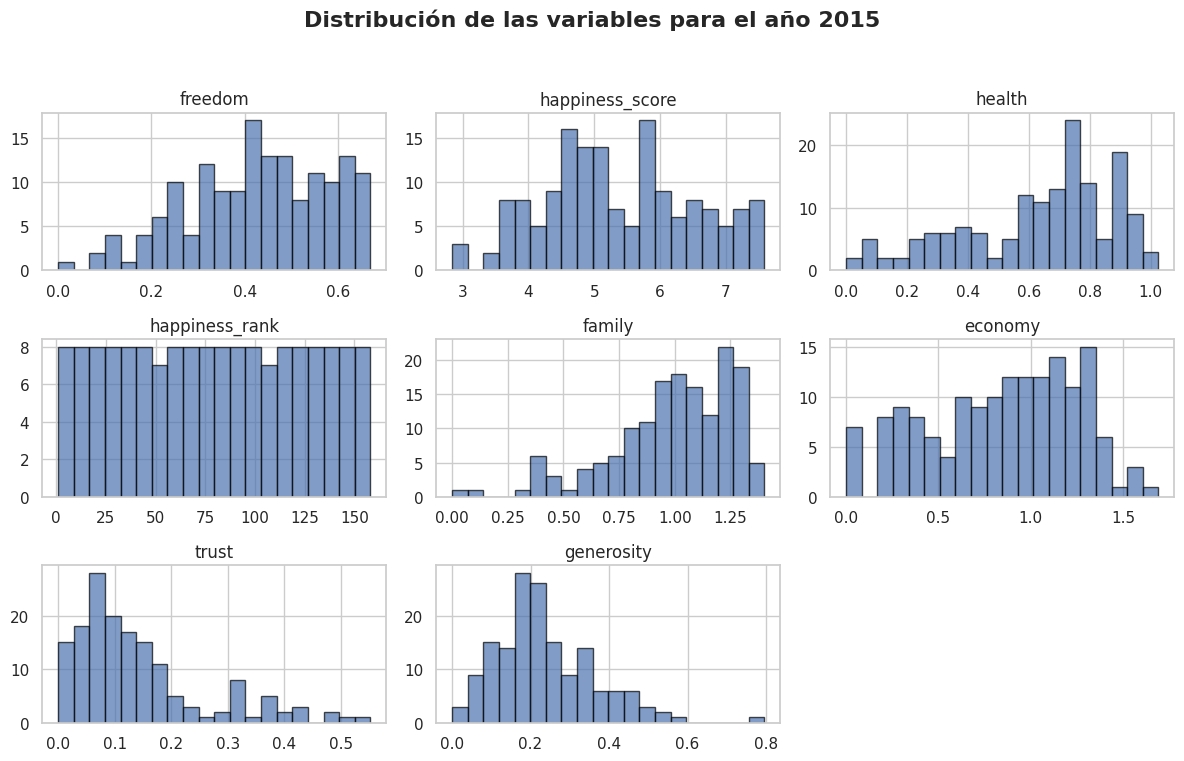

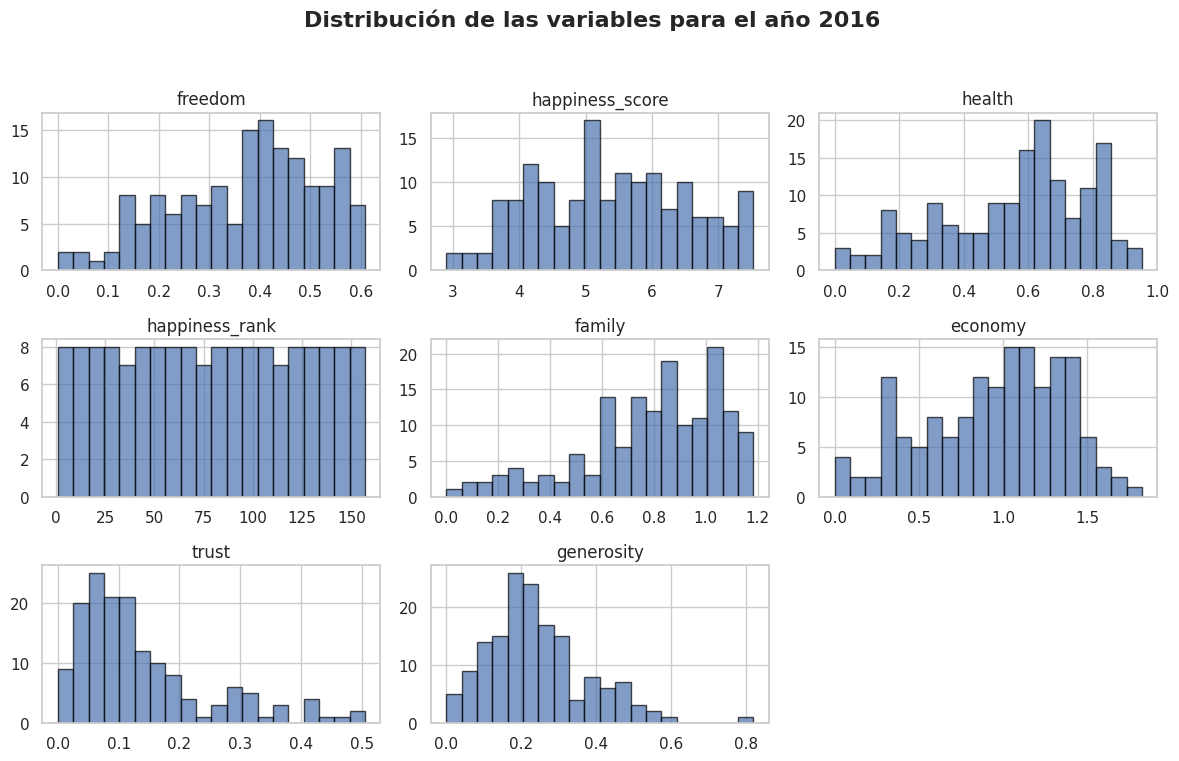

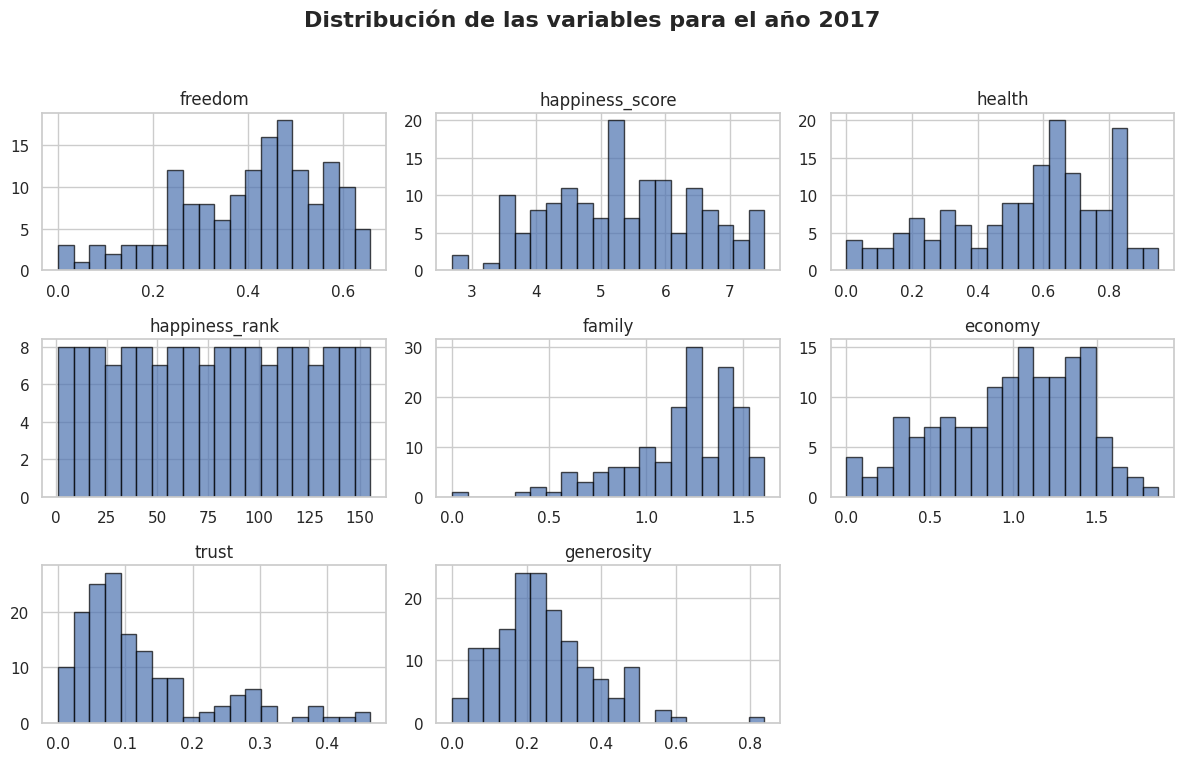

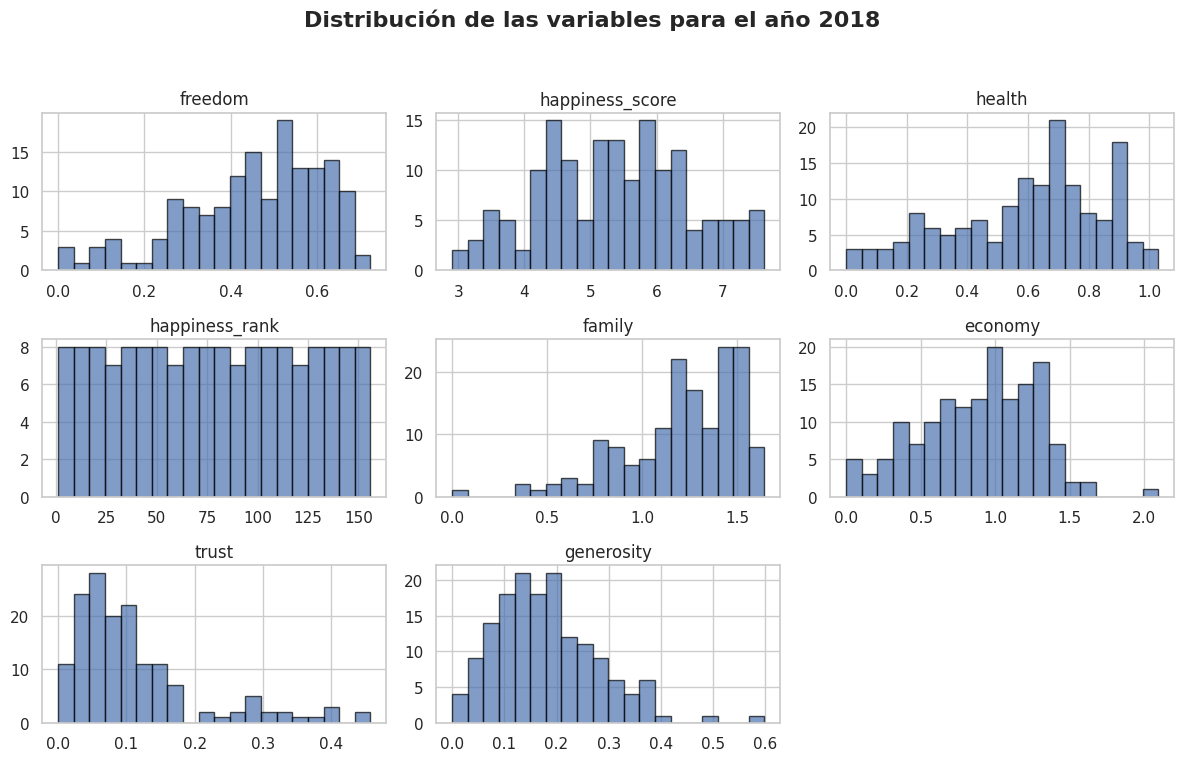

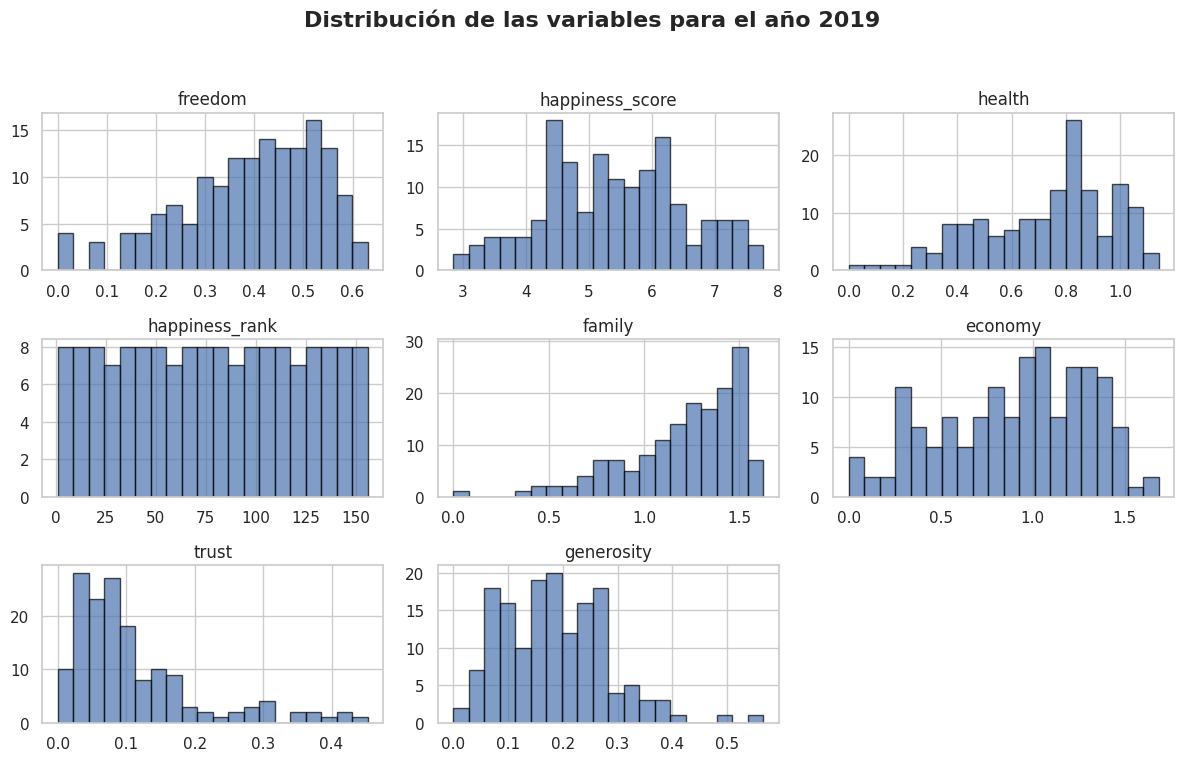

In [ ]:
# Configuración estética de los gráficos
sns.set(style="whitegrid")  # Estilo de fondo blanco con líneas de cuadrícula
plt.rcParams["figure.figsize"] = (12, 8)  # Tamaño por defecto de las figuras

# Iterar sobre los DataFrames
for year, df in dfs.items():
    # Generar el histograma de todas las columnas numéricas
    df_numeric = df.select_dtypes(include=['number'])

    # Crear un histograma para cada columna numérica
    df_numeric.hist(bins=20, edgecolor='black', alpha=0.7)

    # Título y etiquetas
    plt.suptitle(f"Distribución de las variables para el año {year}", fontsize=16, fontweight='bold')
    plt.xlabel('Valor', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)

    # Ajustar el layout para que todo encaje bien
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Mostrar el gráfico
    plt.show()


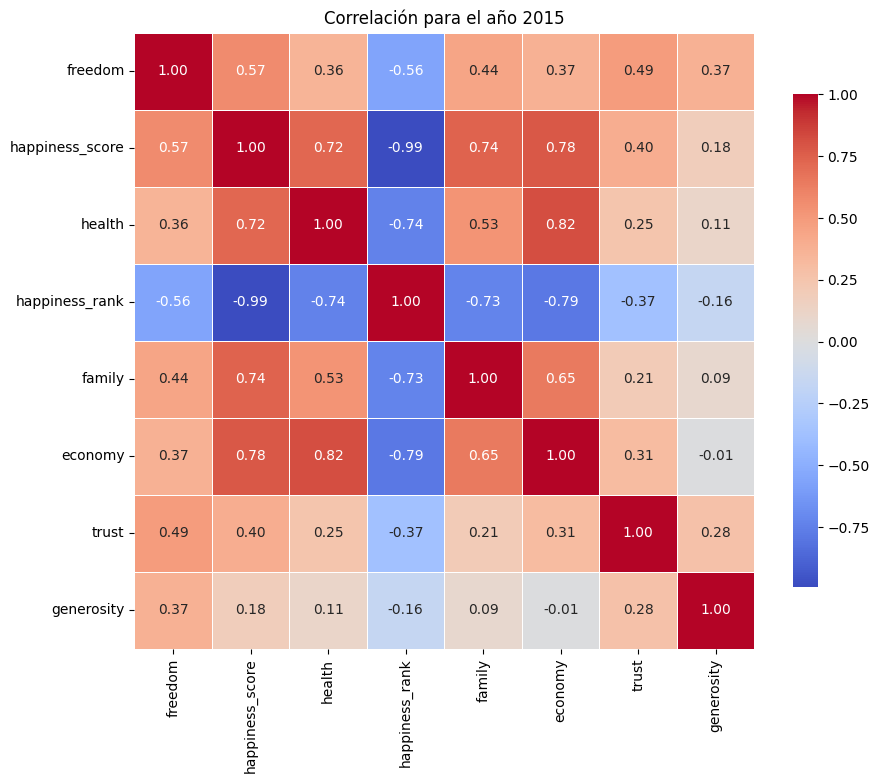

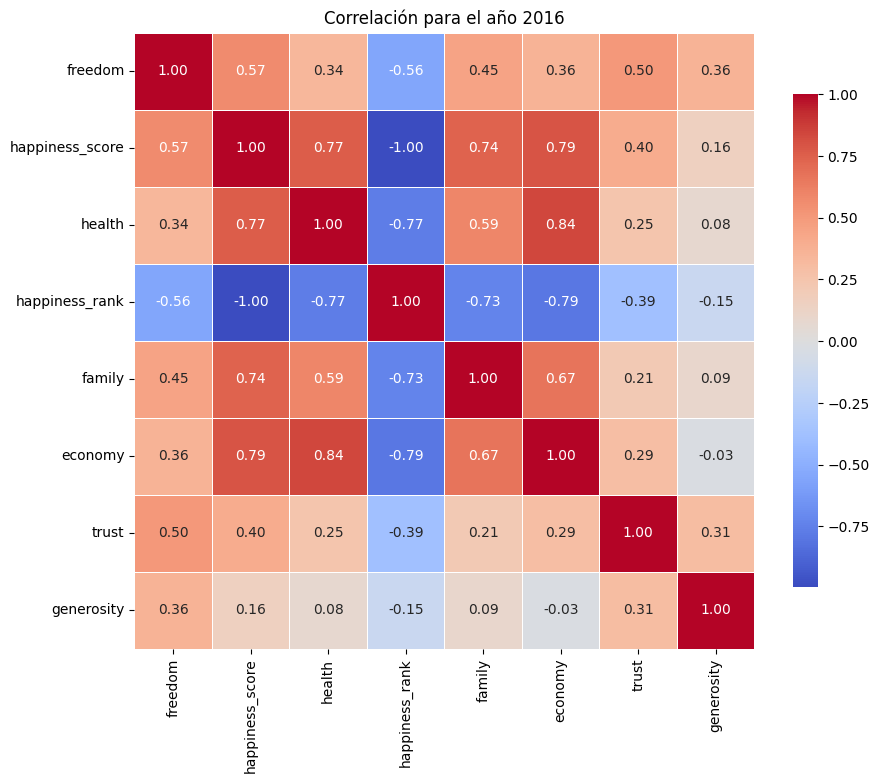

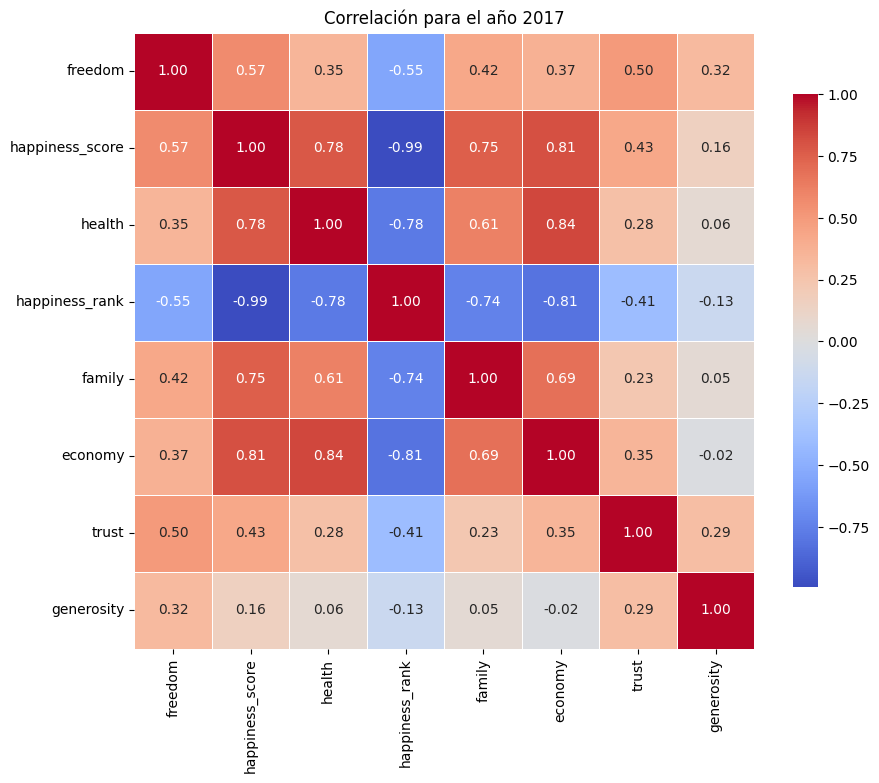

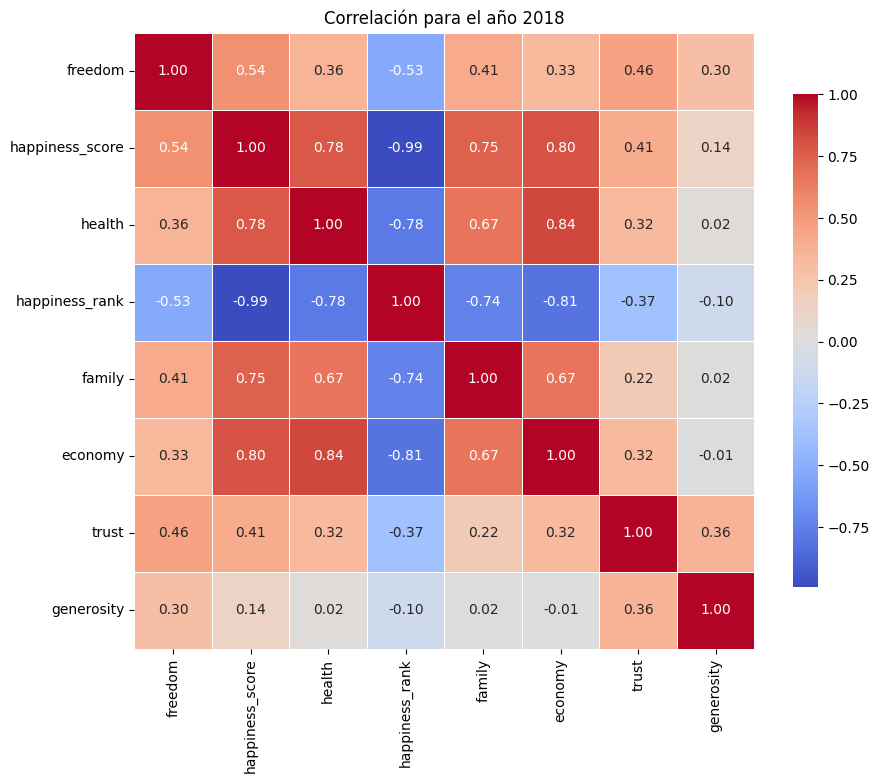

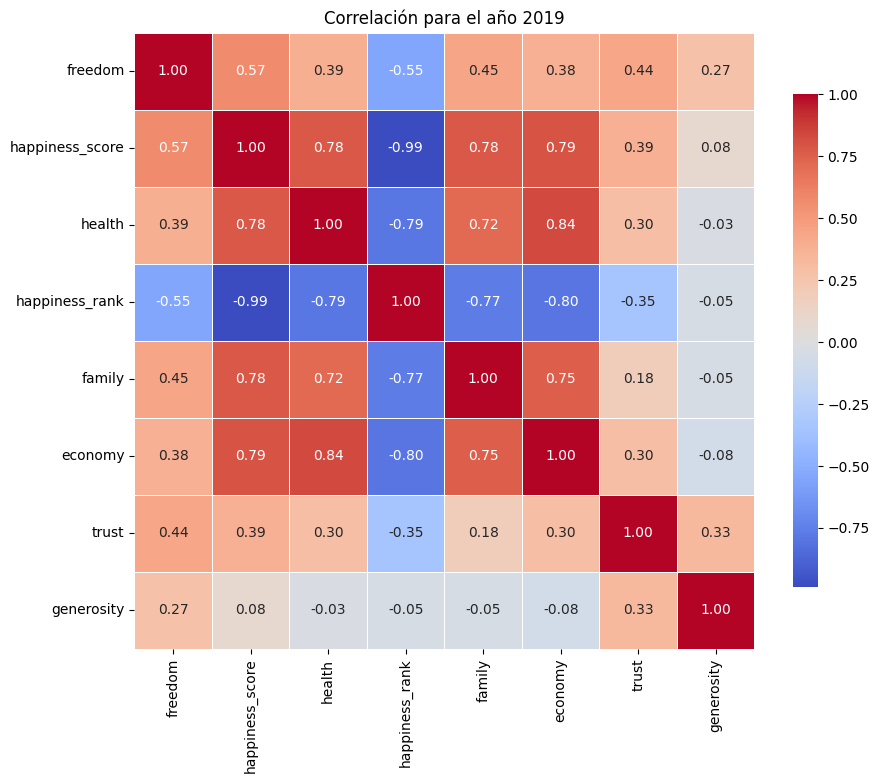

In [ ]:
# Iterar sobre los DataFrames
for year, df in dfs.items():
    # Seleccionar solo las columnas numéricas (sin necesidad de eliminar la columna 'Country')
    df_numeric = df.select_dtypes(include=['number'])

    # Calcular la matriz de correlación para las columnas numéricas
    corr = df_numeric.corr()

    # Crear un mapa de calor para la matriz de correlación
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})

    # Título del gráfico
    plt.title(f"Correlación para el año {year}")
    plt.show()

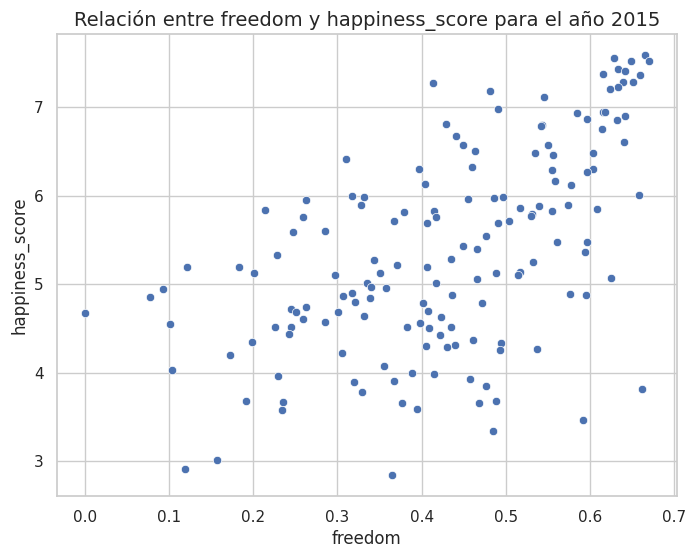

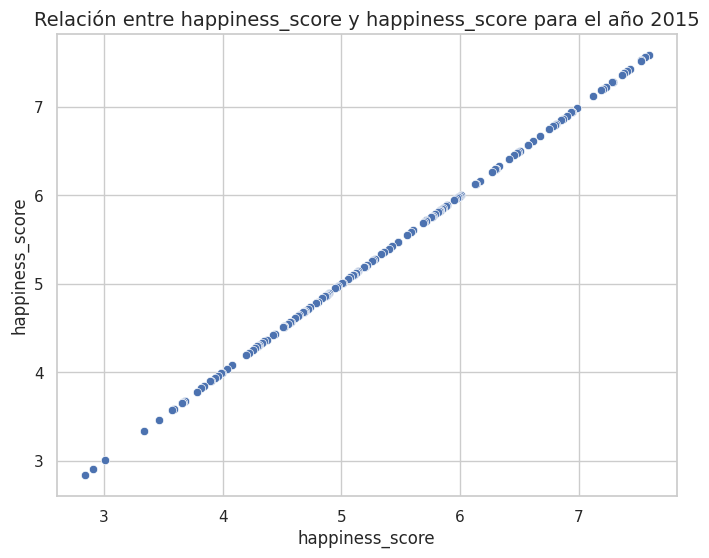

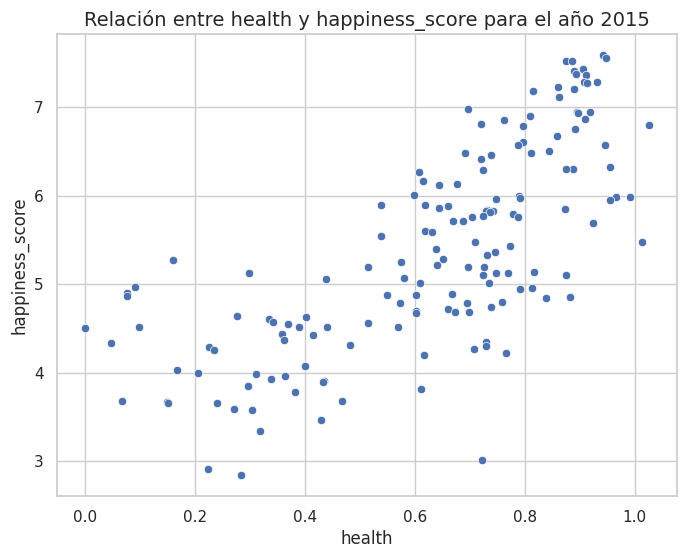

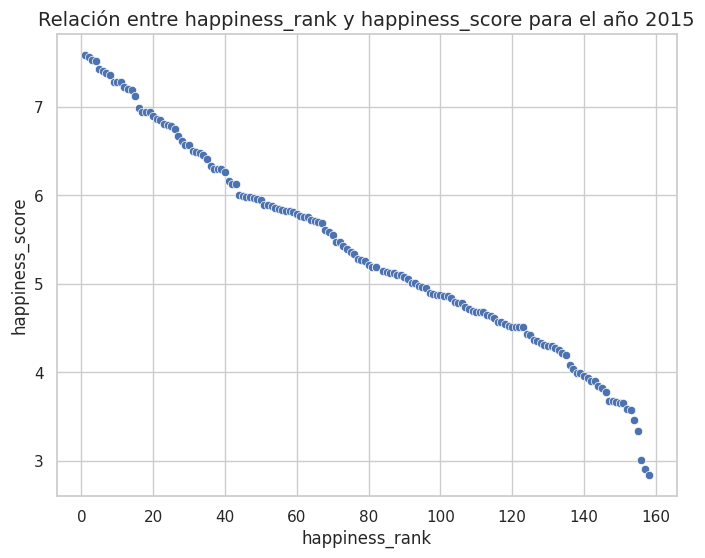

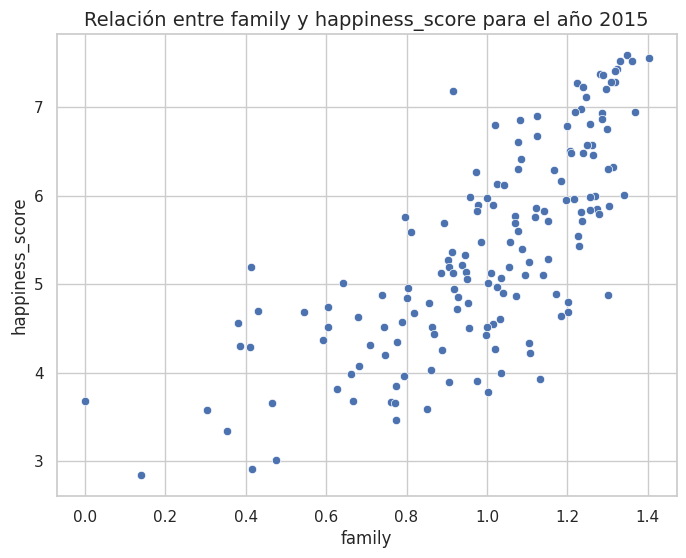

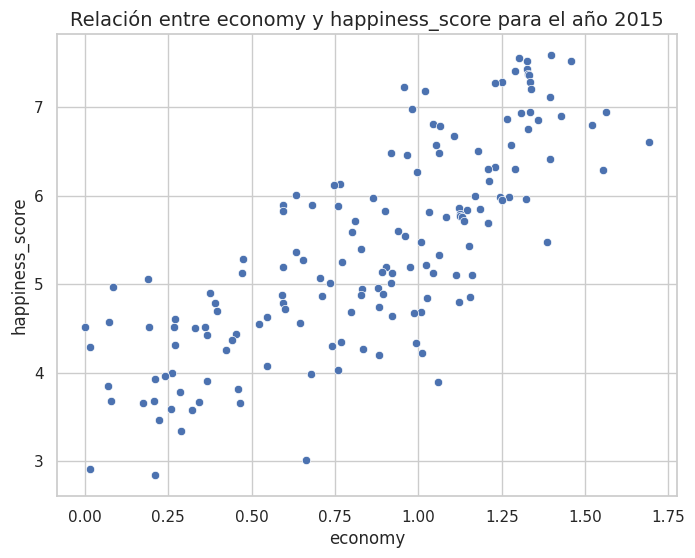

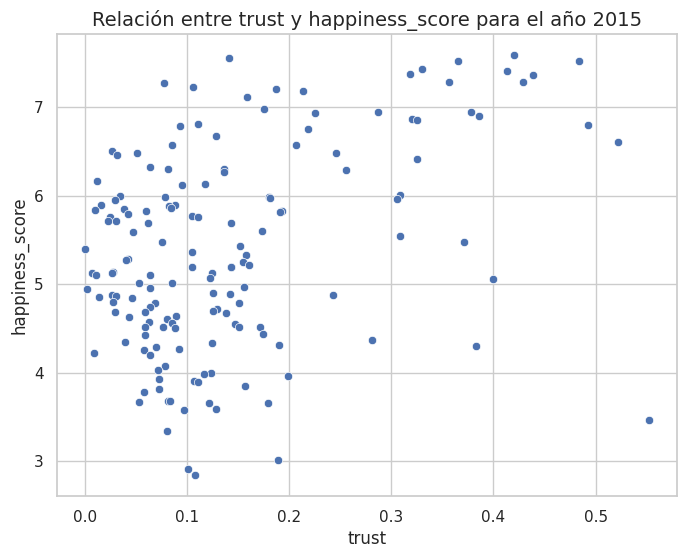

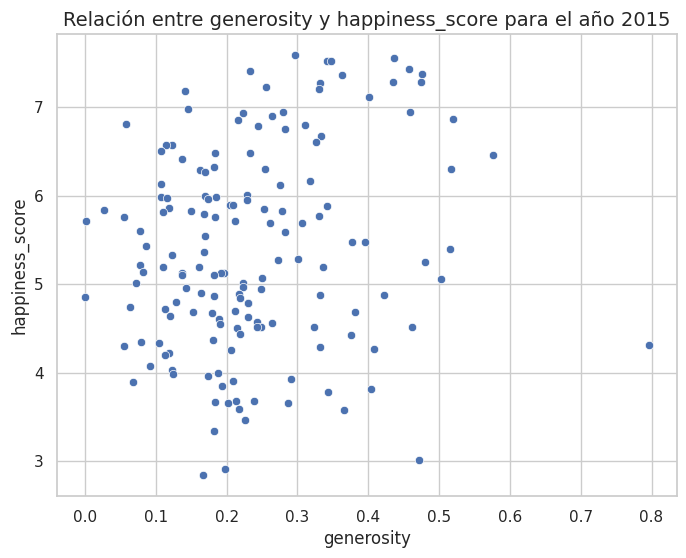

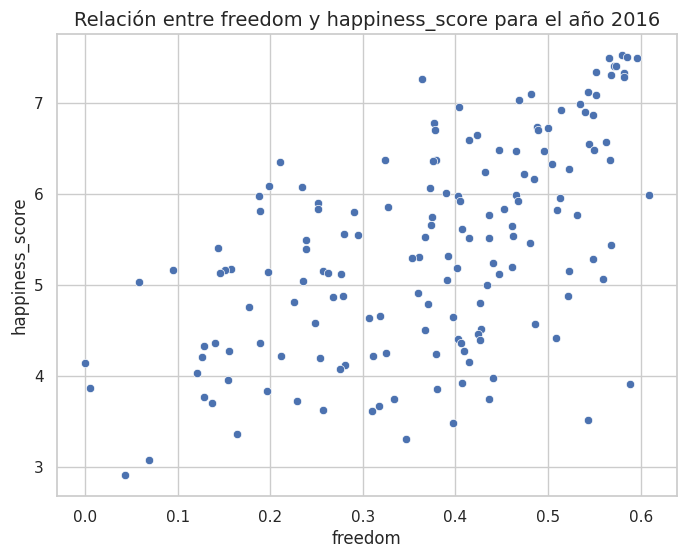

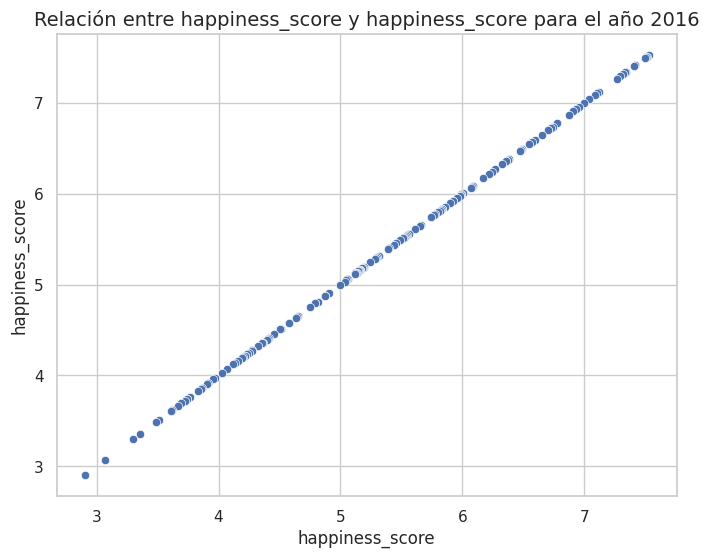

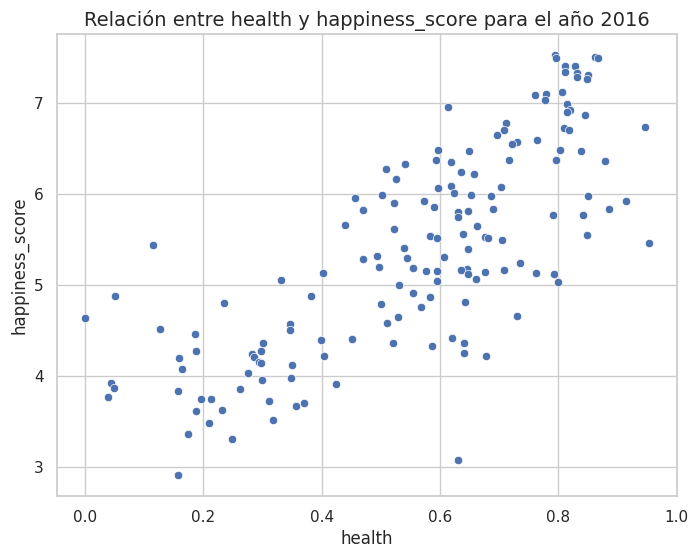

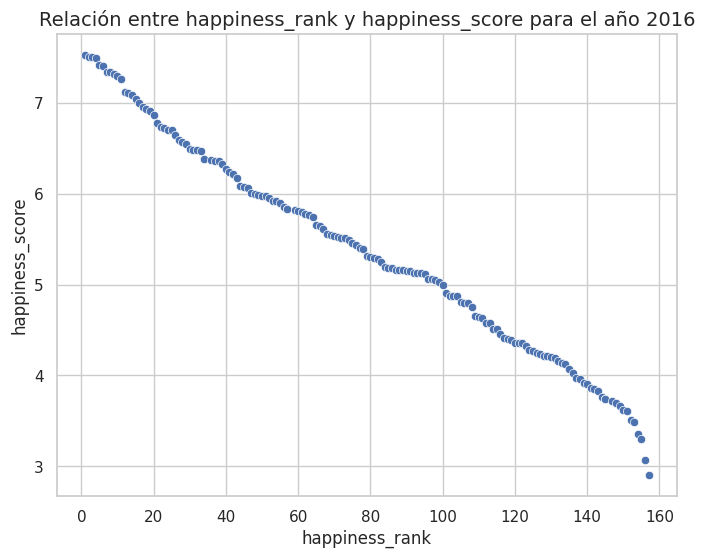

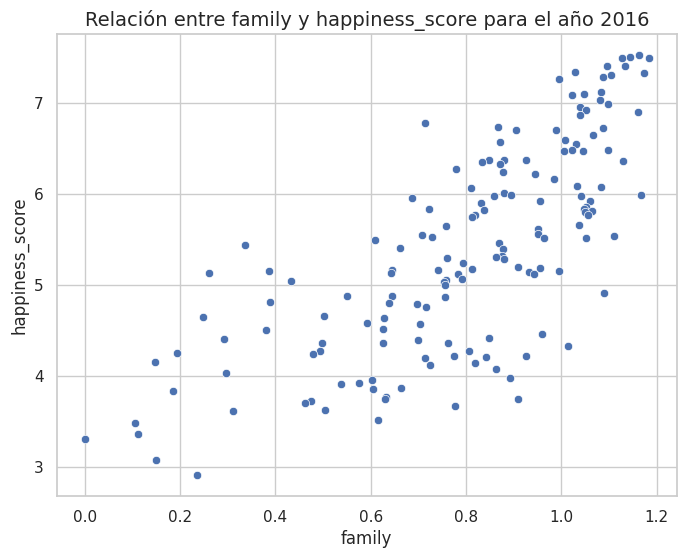

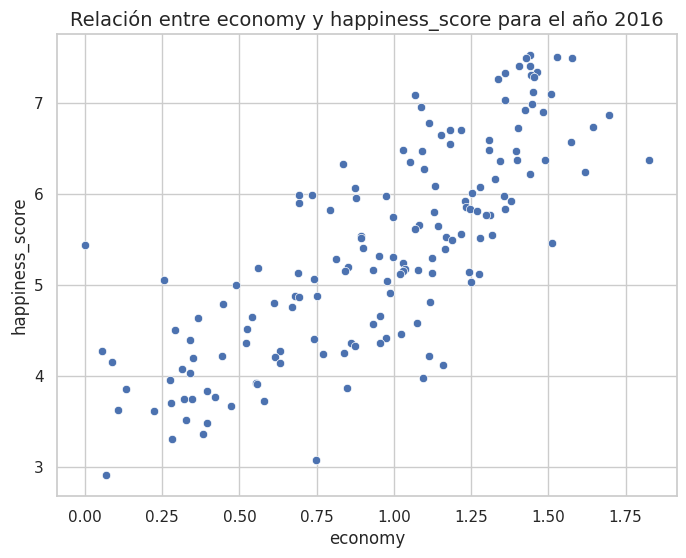

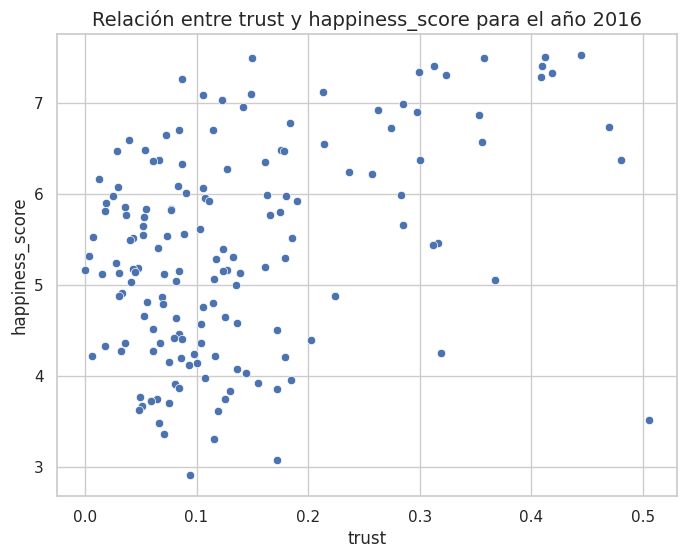

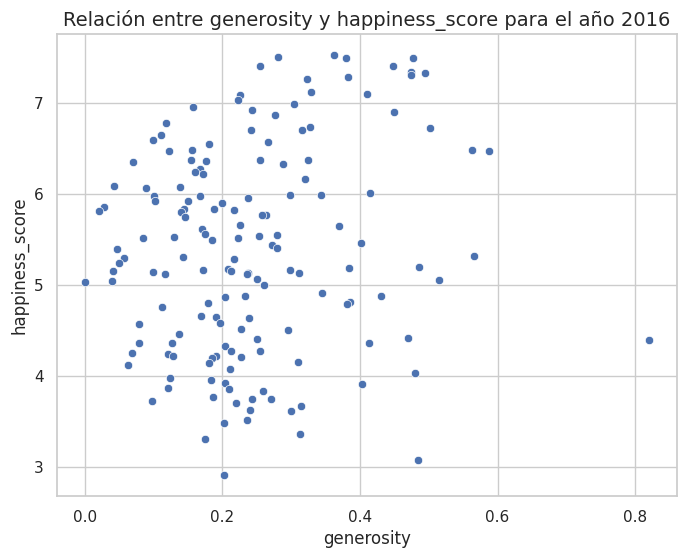

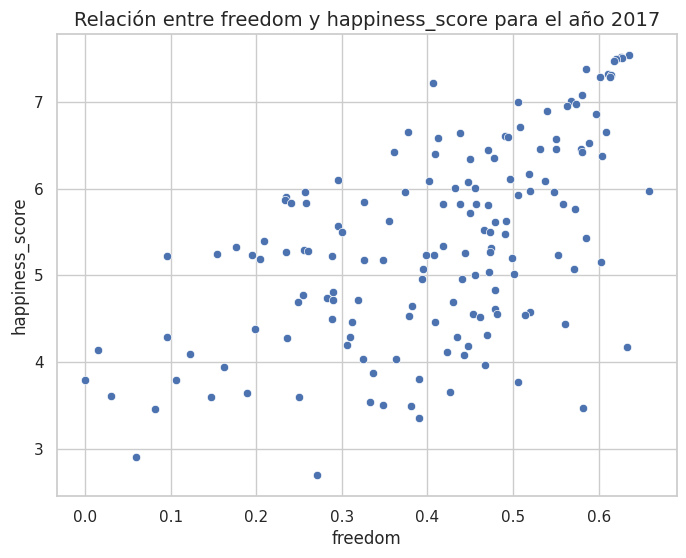

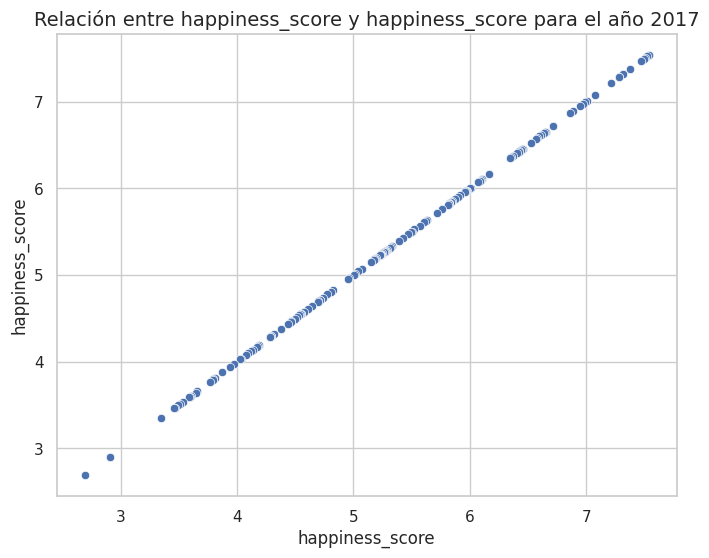

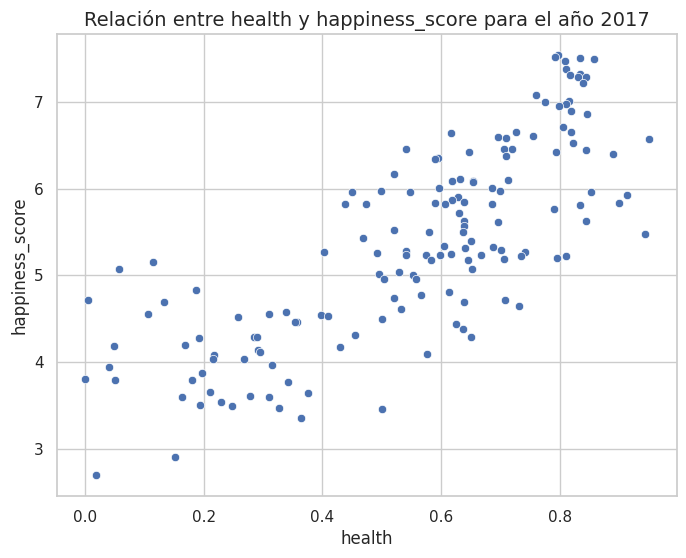

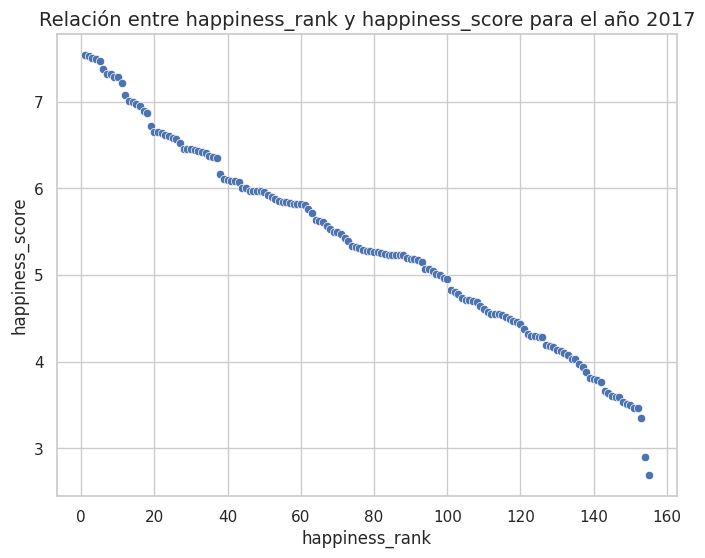

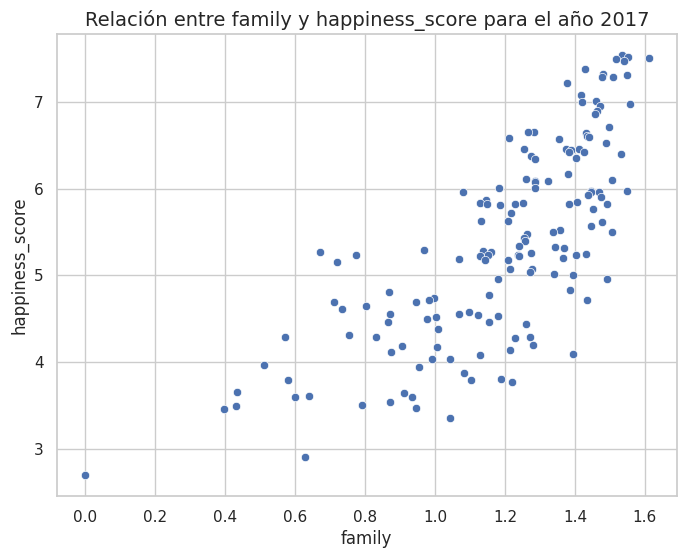

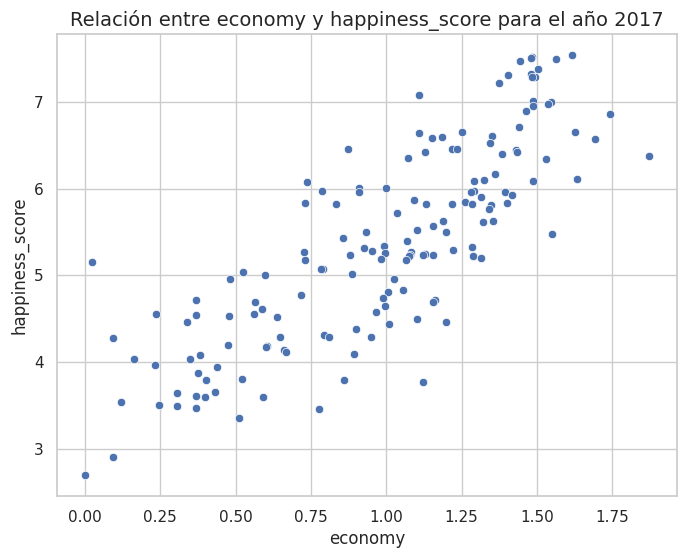

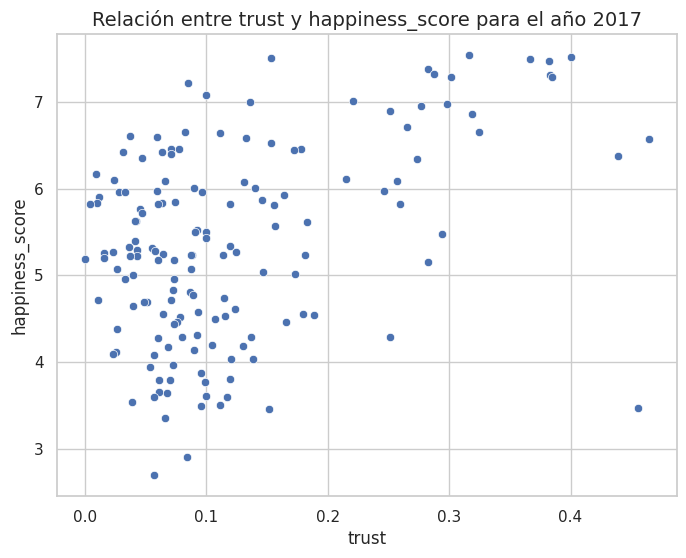

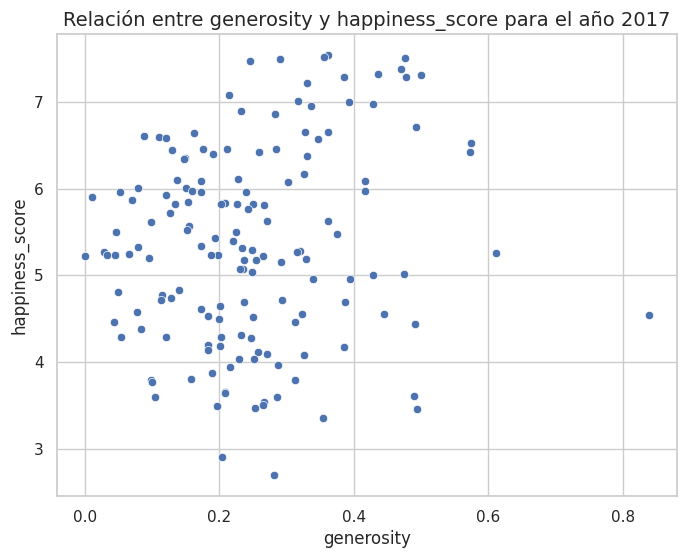

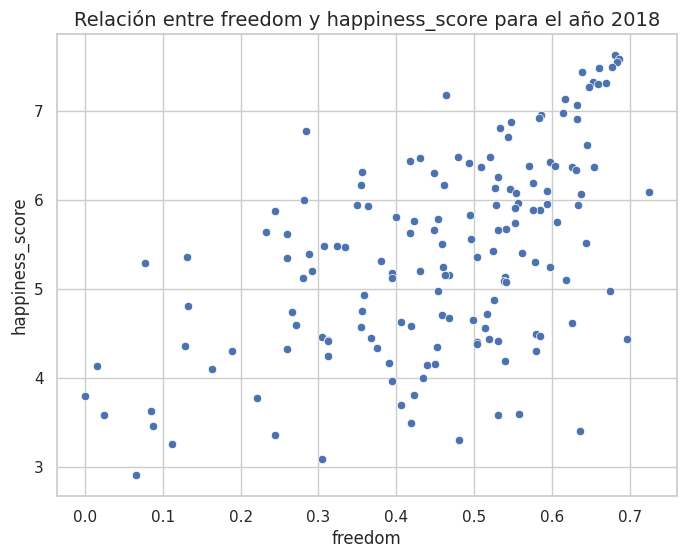

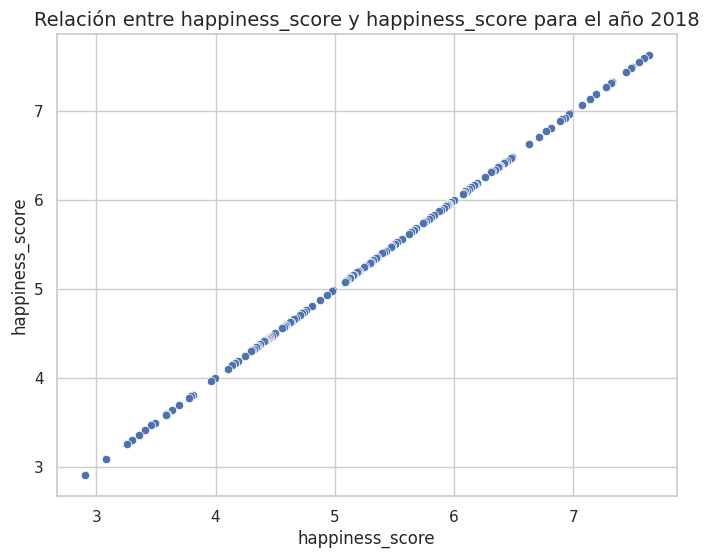

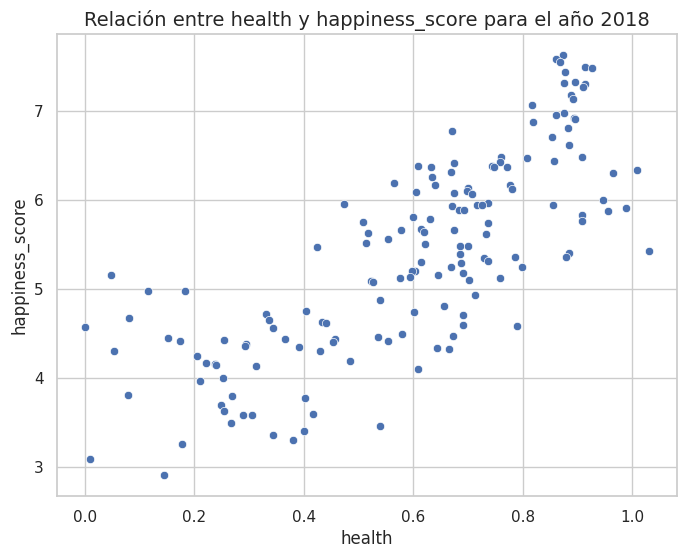

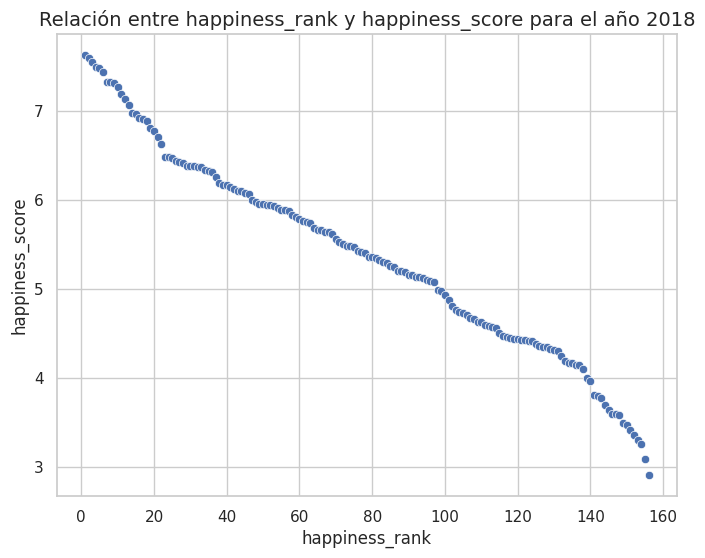

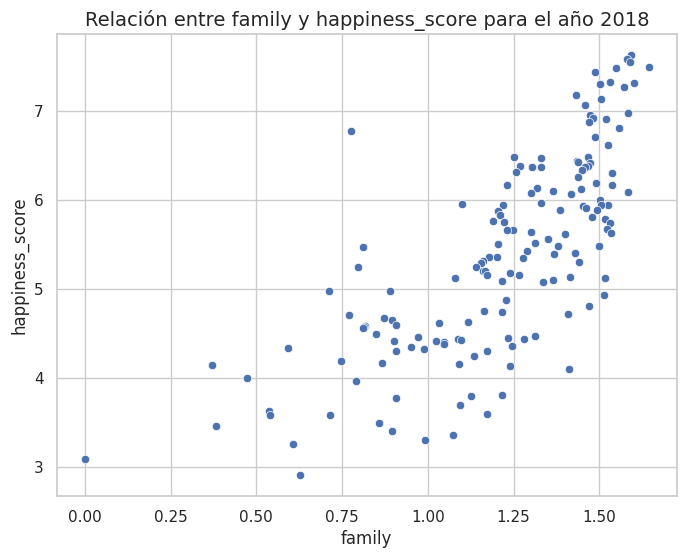

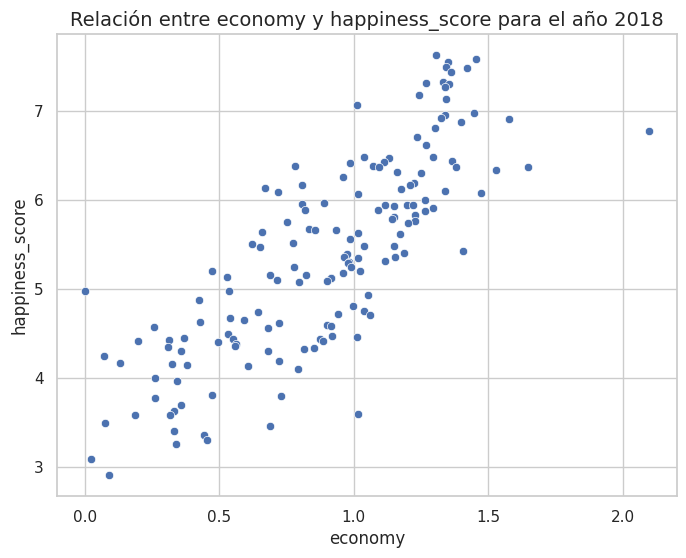

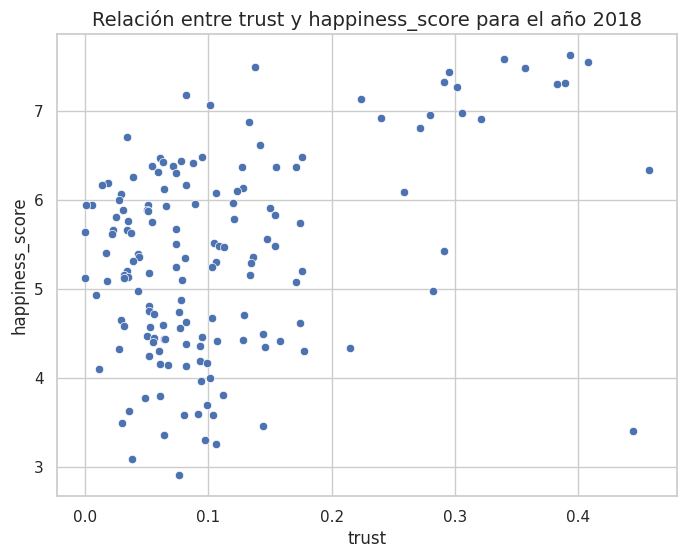

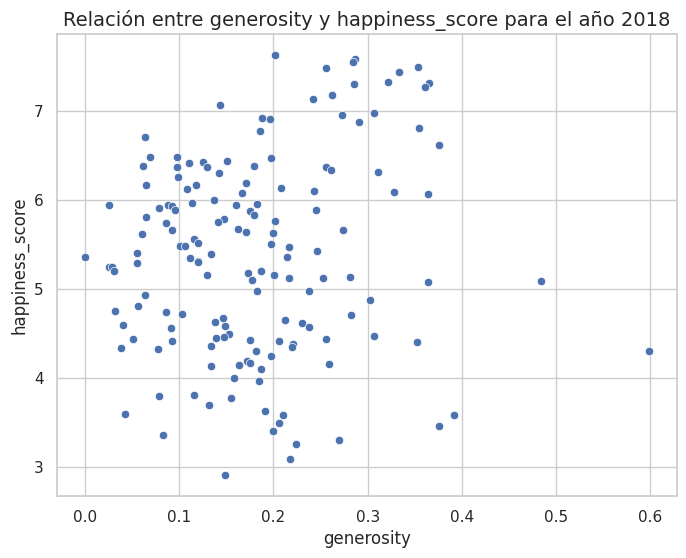

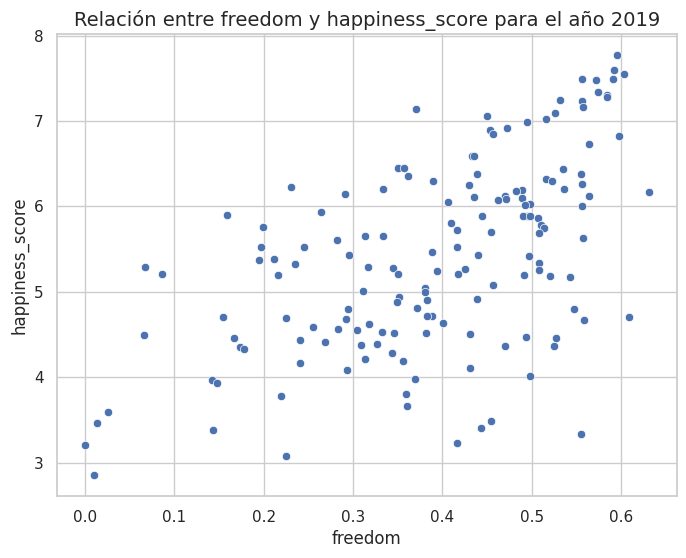

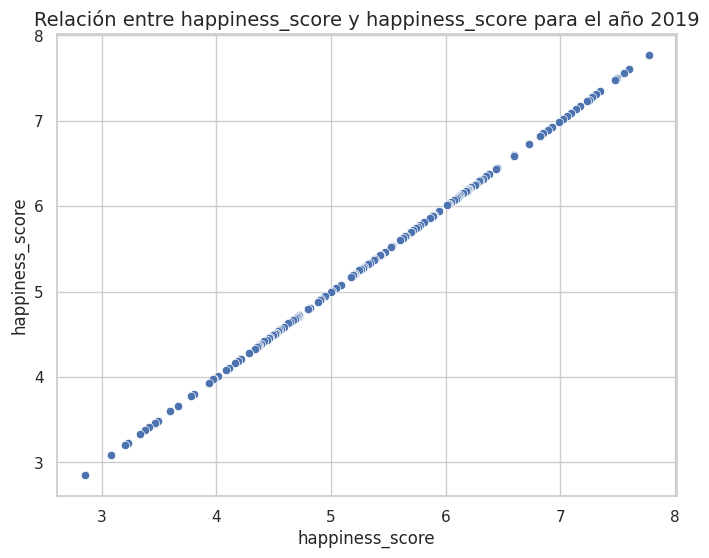

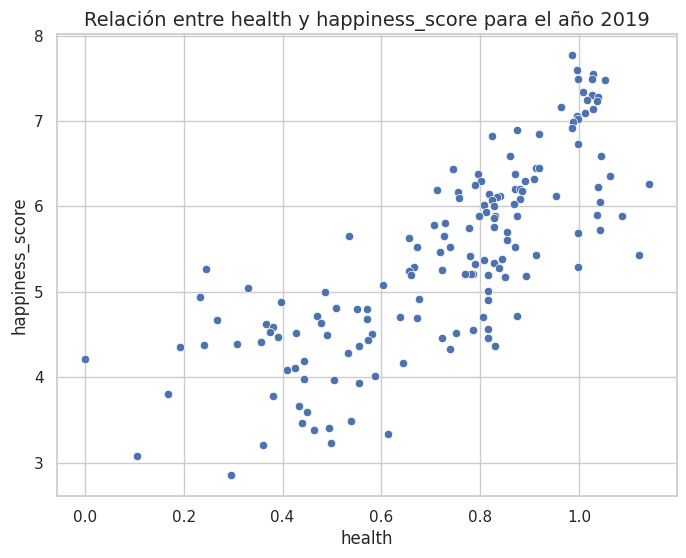

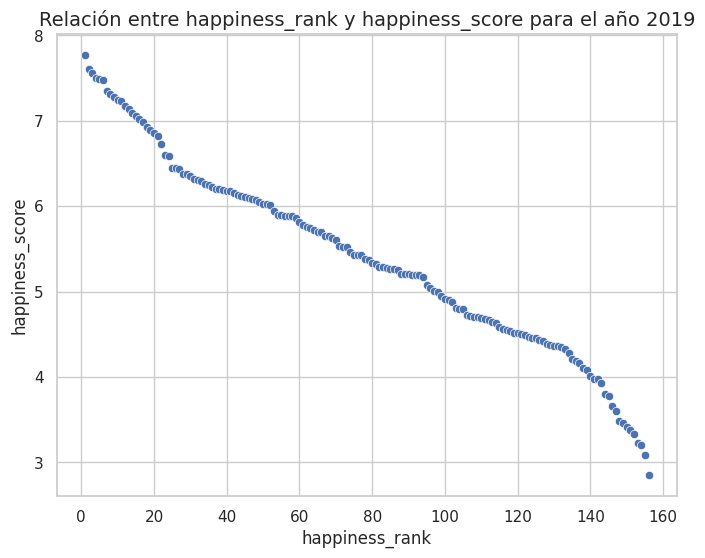

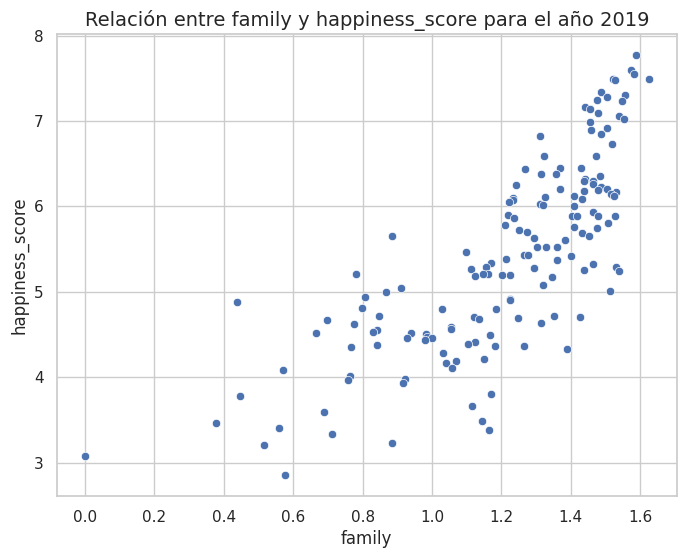

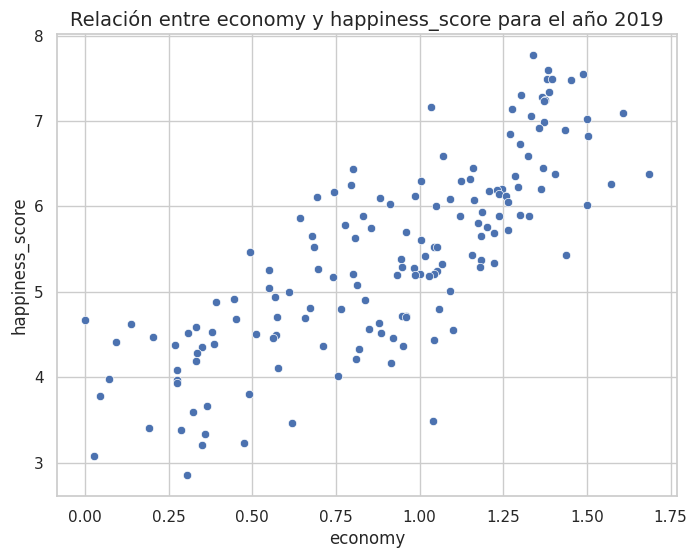

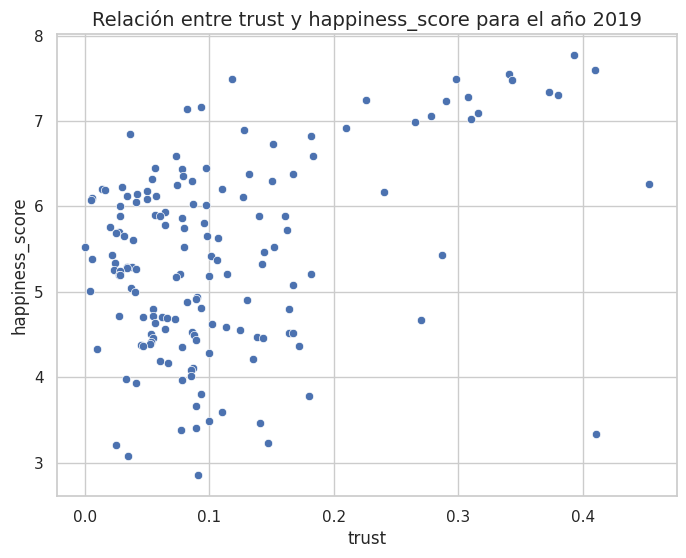

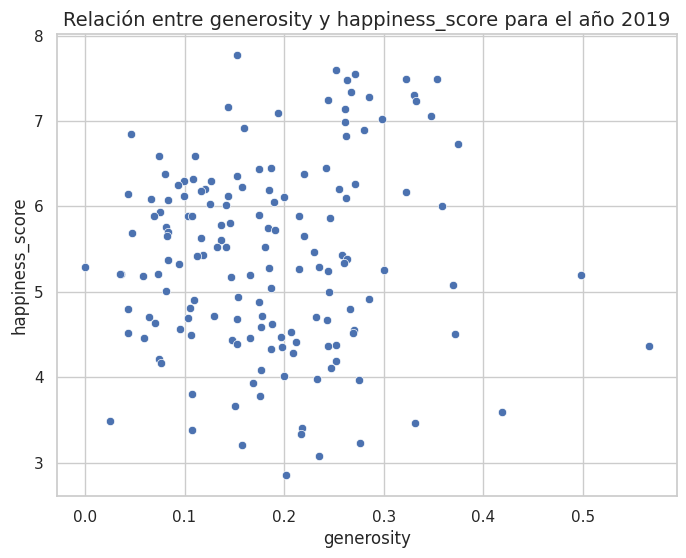

In [ ]:
# Asumiendo que 'target_column' es la columna que quieres predecir
target_column = 'happiness_score'  # Reemplaza 'target_column_name' con el nombre de tu columna objetivo

# Iterar sobre los DataFrames
for year, df in dfs.items():
    # Seleccionar solo las columnas numéricas
    df_numeric = df.select_dtypes(include=['number'])

    # Iterar sobre las columnas numéricas para generar gráficos de dispersión
    for column in df_numeric.columns:
        plt.figure(figsize=(8, 6))  # Ajustar tamaño de la figura

        # Graficar cada columna numérica contra la variable objetivo
        sns.scatterplot(x=df[column], y=df[target_column])

        # Personalizar título y etiquetas
        plt.title(f"Relación entre {column} y {target_column} para el año {year}", fontsize=14)
        plt.xlabel(column, fontsize=12)
        plt.ylabel(target_column, fontsize=12)

        # Mostrar gráfico
        plt.show()
